In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from atmosphere import Atmosphere

atm = Atmosphere()

# Constants
g = 32.17  # ft/s^2
celsius_to_kelvin = 273.15  # K

## Aircraft Data

In [156]:
mmo = 0.85
Nz_limit = 5.0
b = 38.1  # wing span [ft]
S = 255  # wing area [ft^2]
AR = b**2 / S  # aspect ratio
e = 0.8  # Oswald efficiency factor
Ws = 11900  # Standard Weight [lb]

## Data for plot

In [157]:
Vs = 123  # Stall speed IAS [kts]
altitude = 10000  # Altitude to plot [ft]

## Airspeed Calculations

In [158]:
def calc_vt_from_vc(atm, vc_fps, h):
    qc = atm.calc_qc(vc_fps)
    Pa = atm.calc_Pa(h)
    ve_fps = atm.calc_ve(Pa, qc)
    ve = atm.fps_to_kts(ve_fps)
    vt = atm.calc_vt(ve, h)
    return vt

### Utility Functions

In [159]:
def standardize_columns(df, column_mapping):
    # Rename columns based on the exact mapping
    df.rename(columns=column_mapping, inplace=True)
    return df

## Load Level Acceleration Data

In [160]:
# level_accel_data = pd.read_excel("./demo_data/level_accel_data.xlsx", header=1)
level_accel_data = pd.read_excel("./data/level_accel_data.xlsx", sheet_name="Sortie 1 - 10k", header=1)

# For level_accel_data.xlsx
column_mapping = {
    # "Column Name in Excel": "Standardized Name"
    "Time [s]": "Time [s]",
    "Vi [kts]": "Vi [kts]",
    "Hi [ft]": "Hi [ft]",
    "OAT [℃]": "TT [℃]",
    "Wf [lbs]": "Wf [lbs]",
    "ΔVic (AFM) [kts]": "ΔVic (AFM) [kts]",
    "ΔVpc (AFM) [kts]": "ΔVpc (AFM) [kts]",
    "ΔVc (AFM) [kts]": "ΔVc (AFM) [kts]",
    "ΔHic (AFM) [ft]": "ΔHic (AFM) [ft]",
    "ΔHpc (AFM) [ft]": "ΔHpc (AFM) [ft]",
    "Vi error [±kts]": "V_i_error[kts]",
    "Hi error [±ft]": "H_i_error[ft]",
}

# Apply standardization
level_accel_data = standardize_columns(level_accel_data, column_mapping)

## Data Analysis

In [161]:
def fit_quadratic(time, vt_fps):
    # Perform quadratic regression using numpy
    coefficients = np.polyfit(time, vt_fps, 2)
    a, b, c = coefficients

    # Generate the fitted values
    vt_fitted = a * time**2 + b * time + c
    return vt_fitted


def calculate_sep(row):
    term1 = (row["Wt [lbs]"] / Ws) * (row["Vt [kts]"] / g) * row["dVt/dt [ft/s^2]"]
    term2 = (
        2
        / (
            np.pi
            * AR
            * e
            * atm.rho_0
            * atm.get_std_sigma(row["Hc [ft]"])
            * row["Vt [kts]"]
            * S
        )
    ) * ((row["Wt [lbs]"] ** 2 - Ws**2) / Ws)
    return term1 + term2
def calculate_sep_no_fit(row):
    term1 = (row["Wt [lbs]"] / Ws) * (row["Vt [kts]"] / g) * row["dVt/dt [no fit]"]
    term2 = (
        2
        / (
            np.pi
            * AR
            * e
            * atm.rho_0
            * atm.get_std_sigma(row["Hc [ft]"])
            * row["Vt [kts]"]
            * S
        )
    ) * ((row["Wt [lbs]"] ** 2 - Ws**2) / Ws)
    return term1 + term2


def calculate_nz(row):
    term1 = (row["Wt [lbs]"] / Ws) ** 2
    term2 = (np.pi * AR * e * row["qc [psf]"] * S) / Ws**2
    term3 = (row["Wt [lbs]"] / g) * row["dVt/dt [ft/s^2]"]
    return np.sqrt(term1 + term2 * term3)

### Apply to Data

In [162]:
level_accel_data["Wt [lbs]"] = level_accel_data.apply(
    lambda row: row["ZFW [lbs]"] + row["Wf [lbs]"], axis=1
)
level_accel_data["Hc [ft]"] = level_accel_data.apply(
    lambda row: row["Hi [ft]"] + row["ΔHpc (AFM) [ft]"] + row["ΔVic (AFM) [kts]"],
    axis=1,
)
level_accel_data["Vc [kts]"] = level_accel_data.apply(
    lambda row: row["Vi [kts]"] + row["ΔVic (AFM) [kts]"] + row["ΔVpc (AFM) [kts]"],
    axis=1,
)
level_accel_data["Vc [fps]"] = level_accel_data.apply(
    lambda row: atm.kts_to_fps(row["Vc [kts]"]), axis=1
)
level_accel_data["Vt [kts]"] = level_accel_data.apply(
    lambda row: calc_vt_from_vc(atm, row["Vc [fps]"], row["Hc [ft]"]), axis=1
)
level_accel_data["Vt [fps]"] = level_accel_data.apply(
    lambda row: atm.kts_to_fps(row["Vt [kts]"]), axis=1
)
level_accel_data["Mach"] = level_accel_data.apply(
    lambda row: atm.calc_mach(row["Vt [kts]"], row["Hc [ft]"]), axis=1
)
level_accel_data["qc [psf]"] = level_accel_data.apply(
    lambda row: atm.calc_qc(row["Vc [fps]"]), axis=1
)


# Extract the columns
time = level_accel_data["Time [s]"]
vt_fps = level_accel_data["Vt [fps]"]
# Apply the function to get the fitted values
level_accel_data["Vt_fitted [fps]"] = fit_quadratic(time, vt_fps)
level_accel_data["dVt/dt [ft/s^2]"] = np.gradient(
    level_accel_data["Vt_fitted [fps]"], level_accel_data["Time [s]"]
)
level_accel_data["dVt/dt [no fit]"] = np.gradient(
    level_accel_data["Vt [fps]"], level_accel_data["Time [s]"]
)

level_accel_data["sep [ft/s]"] = level_accel_data.apply(calculate_sep, axis=1)
level_accel_data["sep [no fit]"] = level_accel_data.apply(calculate_sep_no_fit, axis=1)
level_accel_data["ROC [ft/min]"] = level_accel_data.apply(
    lambda row: row["sep [ft/s]"] * 60, axis=1
)
level_accel_data["nz [g]"] = level_accel_data.apply(calculate_nz, axis=1)
level_accel_data["Vts [fps]"] = level_accel_data.apply(
    lambda row: (
        row["Vt [fps]"] * np.sqrt((row["TT [℃]"] + celsius_to_kelvin) / atm.T_0)
    ),
    axis=1,
)
level_accel_data["ωs [rad/s]"] = level_accel_data.apply(
    lambda row: (g * np.sqrt(row["nz [g]"] ** 2 - 1) / row["Vts [fps]"]), axis=1
)
level_accel_data["ωs [deg/s]"] = level_accel_data.apply(
    lambda row: np.rad2deg(row["ωs [rad/s]"]), axis=1
)
level_accel_data["Rs [ft]"] = level_accel_data.apply(
    lambda row: (row["Vts [fps]"] ** 2) / (g * np.sqrt(row["nz [g]"] ** 2 - 1)), axis=1
)

/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_12067/3581323717.py:47: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(term1 + term2 * term3)
/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_12067/3881073726.py:54: RuntimeWarning: invalid value encountered in sqrt
  lambda row: (g * np.sqrt(row["nz [g]"] ** 2 - 1) / row["Vts [fps]"]), axis=1
/var/folders/vd/qhfmft5n73n6bxz9rqb6m8h00000gn/T/ipykernel_12067/3881073726.py:60: RuntimeWarning: invalid value encountered in sqrt
  lambda row: (row["Vts [fps]"] ** 2) / (g * np.sqrt(row["nz [g]"] ** 2 - 1)), axis=1


In [163]:
level_accel_data

,Time [s],Vi [kts],Hi [ft],TT [℃],Wf [lbs],ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,dVt/dt [ft/s^2],dVt/dt [no fit],sep [ft/s],sep [no fit],ROC [ft/min],nz [g],Vts [fps],ωs [rad/s],ωs [deg/s],Rs [ft]
0,0,148,10010,-8,2800,8620,0,0,0,0,...,5.868849,7.348342,28.361957,35.943055,1701.717446,2.225193,278.106587,0.229943,13.174757,1209.459408
1,10,186,9940,-8,2800,8620,0,0,0,0,...,5.647452,6.571344,34.911183,40.845245,2094.671004,2.662934,348.596317,0.227761,13.049771,1530.532448
2,20,216,9930,-8,2800,8620,0,0,0,0,...,5.204657,5.791625,37.584971,41.956133,2255.098270,2.939810,404.179178,0.220036,12.607154,1836.874676
3,30,246,9950,-8,2800,8620,0,0,0,0,...,4.761862,5.474314,39.300773,45.335358,2358.046373,3.186947,459.709850,0.211756,12.132709,2170.944216
4,40,273,9930,-8,2800,8620,0,0,0,0,...,4.319066,3.825303,39.589989,34.957443,2375.399316,3.364498,509.205018,0.202953,11.628338,2508.982715
5,50,286,9940,-8,2800,8620,0,0,0,0,...,3.876271,2.864796,37.183651,27.248569,2231.019059,3.347532,533.099081,0.192784,11.045693,2765.270457
6,60,303,9940,-8,2800,8620,0,0,0,0,...,3.433476,3.328607,34.848792,33.758701,2090.927519,3.347294,564.166715,0.182153,10.436611,3097.209533
7,70,321,9940,-8,2800,8620,0,0,0,0,...,2.990681,3.422122,32.099227,36.844638,1925.953610,3.322350,596.959102,0.170738,9.782569,3496.345006
8,80,339,9960,-8,2800,8620,0,0,0,0,...,2.547886,2.548568,28.812639,28.820551,1728.758326,3.255529,629.820837,0.158247,9.066875,3979.990294
9,90,348,9930,-8,2800,8620,0,0,0,0,...,2.105091,1.410837,24.315520,16.053985,1458.931192,3.062060,645.853908,0.144159,8.259681,4480.161487


## Plot Climb Performance

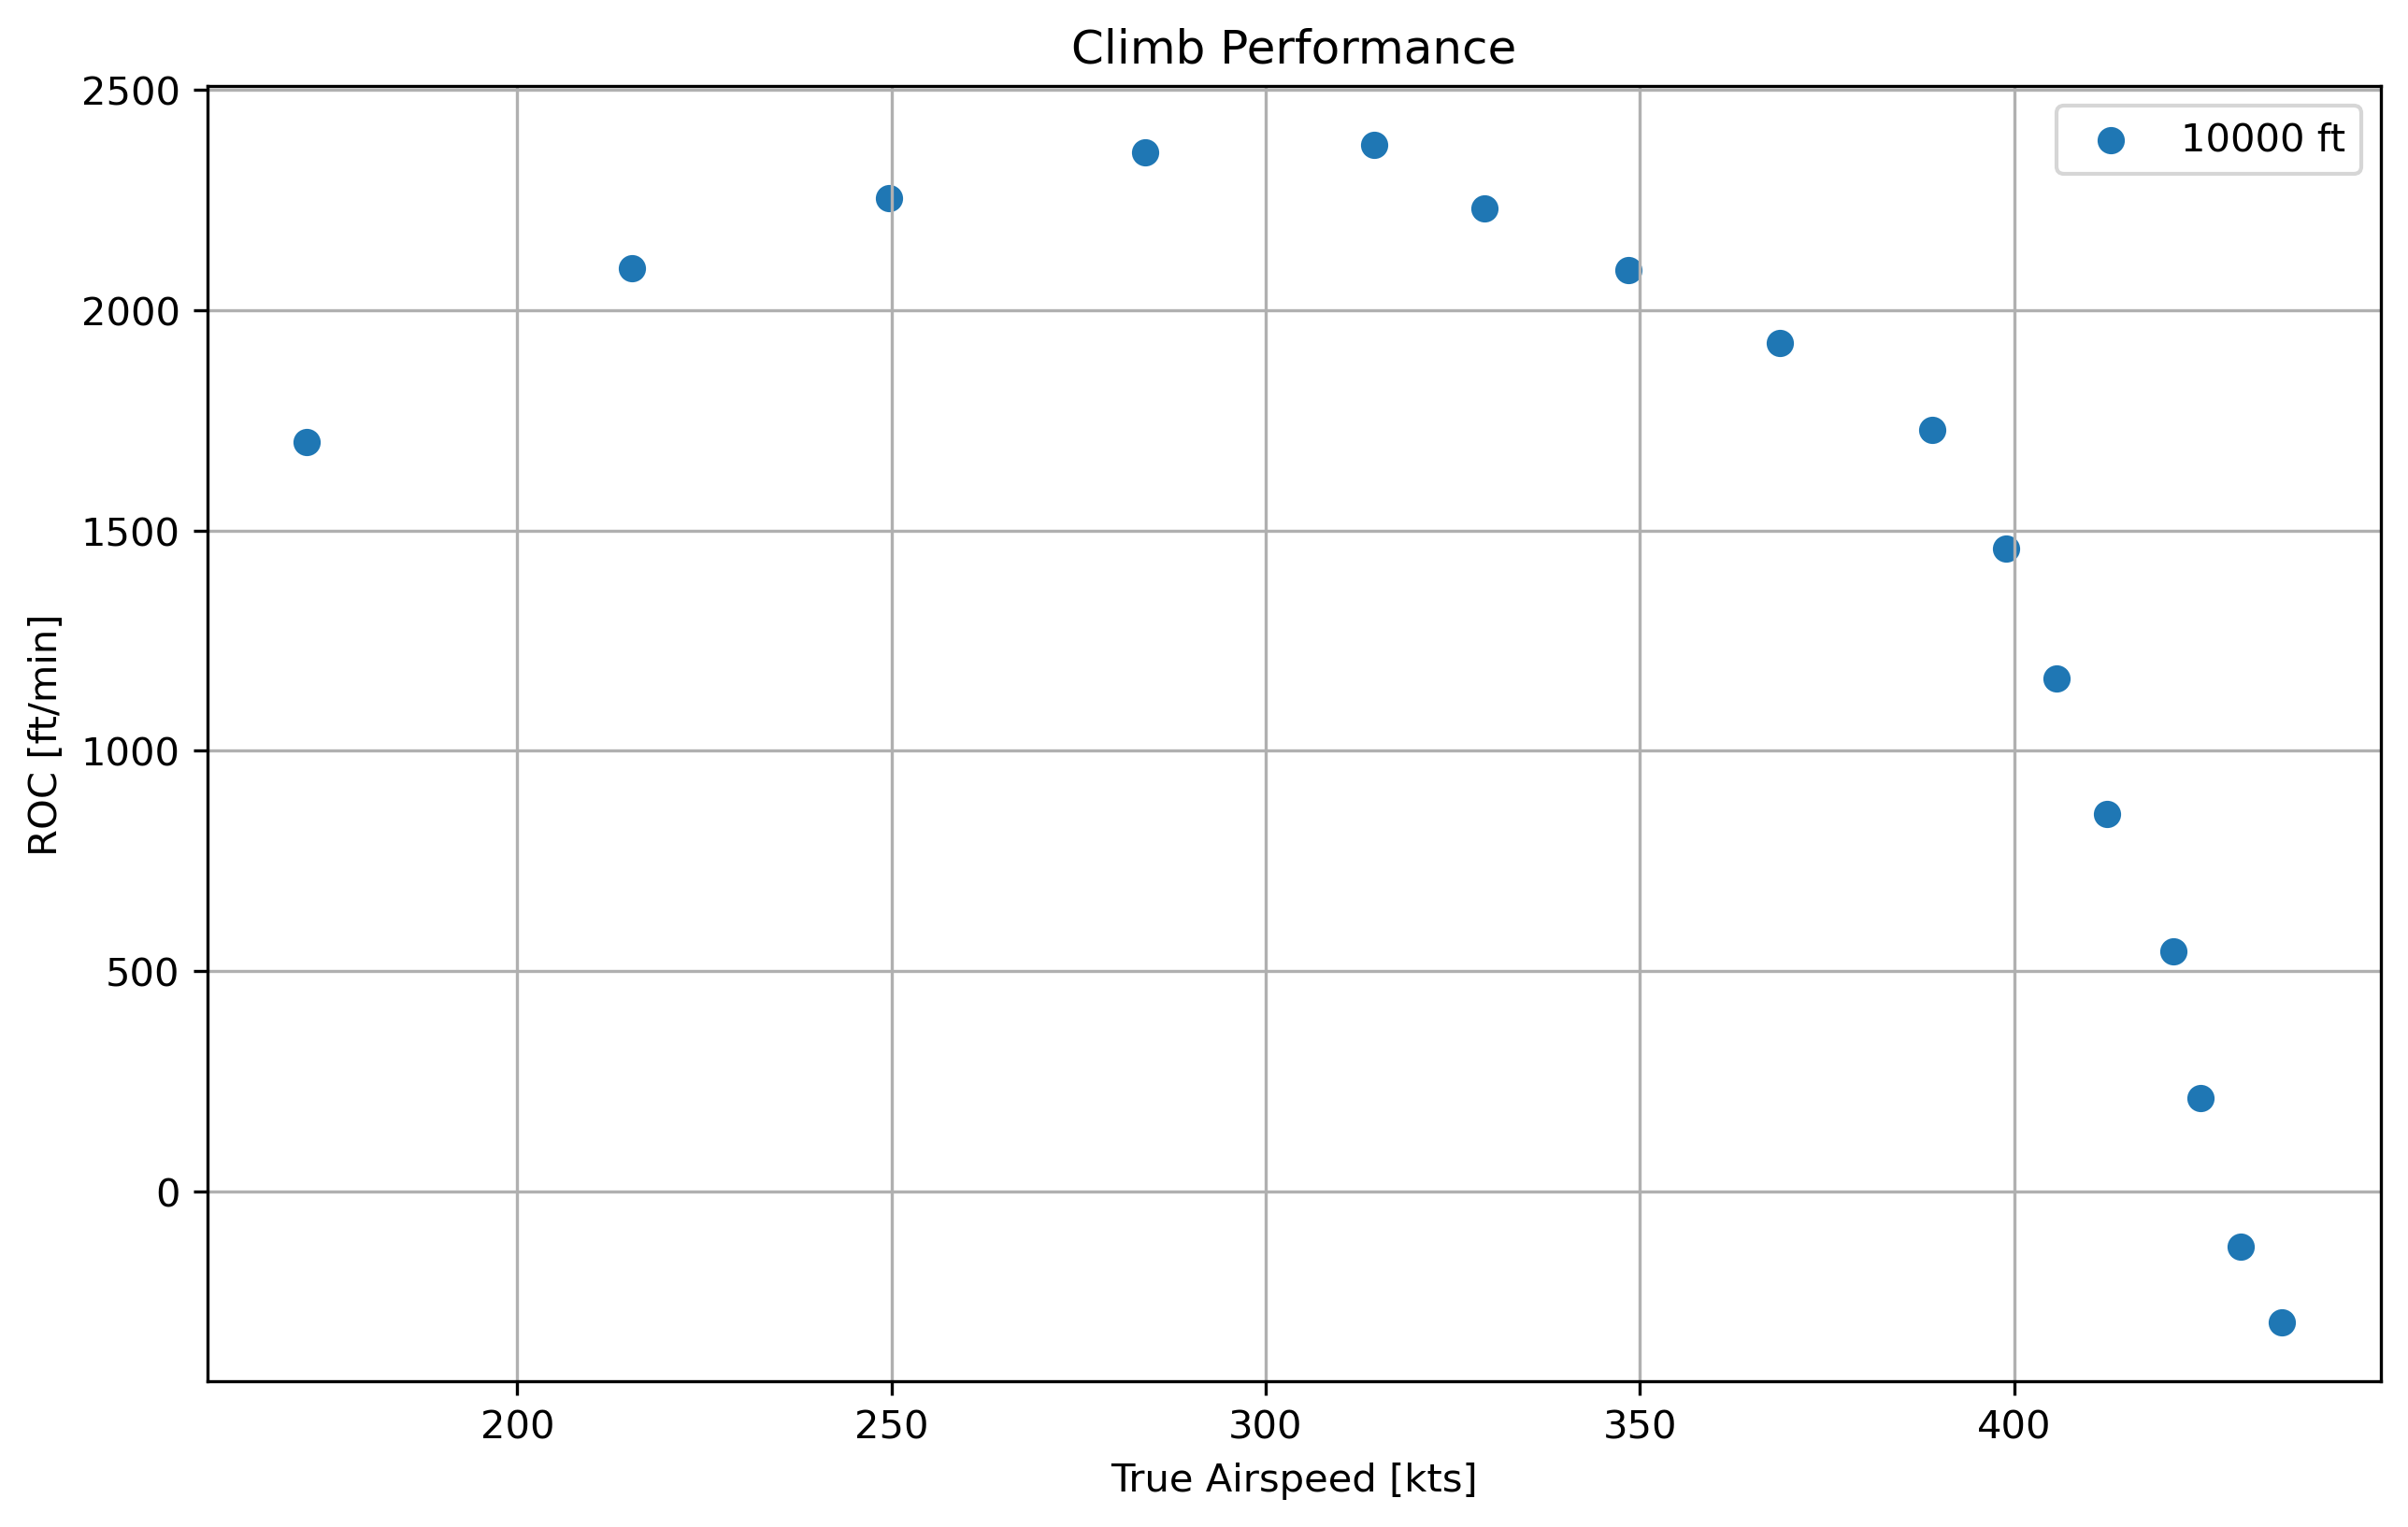

In [164]:
plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(
    level_accel_data["Vt [kts]"],
    level_accel_data["ROC [ft/min]"],
    label=f"{altitude} ft",
)

plt.xlabel("True Airspeed [kts]")
plt.ylabel("ROC [ft/min]")
plt.title("Climb Performance")
plt.legend()
plt.grid()
plt.show()

## Create SEP Boundary limits

In [165]:
g_space = np.linspace(1, Nz_limit, 1000)
sigma = atm.get_std_sigma(altitude)
lift_boundary_speeds = []
for g_step in g_space:
    lift_boundary_speeds.append(Vs * (np.sqrt(g_step) / np.sqrt(sigma)))

lift_boundary_turn_rates = []
for i, g_step in enumerate(g_space):
    lift_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(g_step**2 - 1) / atm.kts_to_fps(lift_boundary_speeds[i]))
    )

max_lift_speed = max(lift_boundary_speeds)
max_speed = atm.calc_vt_from_mach(mmo, altitude)

nz_boundary_speeds = np.linspace(max_lift_speed, max_speed, 100)
nz_boundary_turn_rates = []
for speed in nz_boundary_speeds:
    nz_boundary_turn_rates.append(
        np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(speed))
    )

mmo_speeds = np.array([max_speed, max_speed])
mmo_turn_rates = np.array([0])
mmo_turn_rates = np.append(
    mmo_turn_rates, np.rad2deg(g * np.sqrt(Nz_limit**2 - 1) / atm.kts_to_fps(max_speed))
)

## Create fixed radius and g lines

In [166]:
g_lines = np.array([1.1, 1.5, 2, 2.5, 3, 4, 5, 6, 7])
min_lift_boundary_speed = min(lift_boundary_speeds)
min_line_speed = min_lift_boundary_speed * 0.99
max_line_speed = max_speed * 1.02
lines_speeds = np.linspace(min_line_speed, max_line_speed, 100)

g_lines_turn_rates = []
for g_line in g_lines:
    turn_rates = []
    for speed in lines_speeds:
        turn_rate = np.rad2deg(g * np.sqrt(g_line**2 - 1) / atm.kts_to_fps(speed))
        turn_rates.append(turn_rate)
    g_lines_turn_rates.append(turn_rates)

# radius_lines = np.array([1000, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 8000, 10000, 15000, 20000])
radius_lines = np.array([1000, 1500, 2000, 2500, 3000, 4000, 6000])
radius_lines_turn_rates = []
radius_lines_speeds = [min_line_speed, max_line_speed]
for radius in radius_lines:
    turn_rates = []
    for speed in radius_lines_speeds:
        turn_rate = np.rad2deg(speed / radius)
        turn_rates.append(turn_rate)
    radius_lines_turn_rates.append(turn_rates)

## Plot SEP

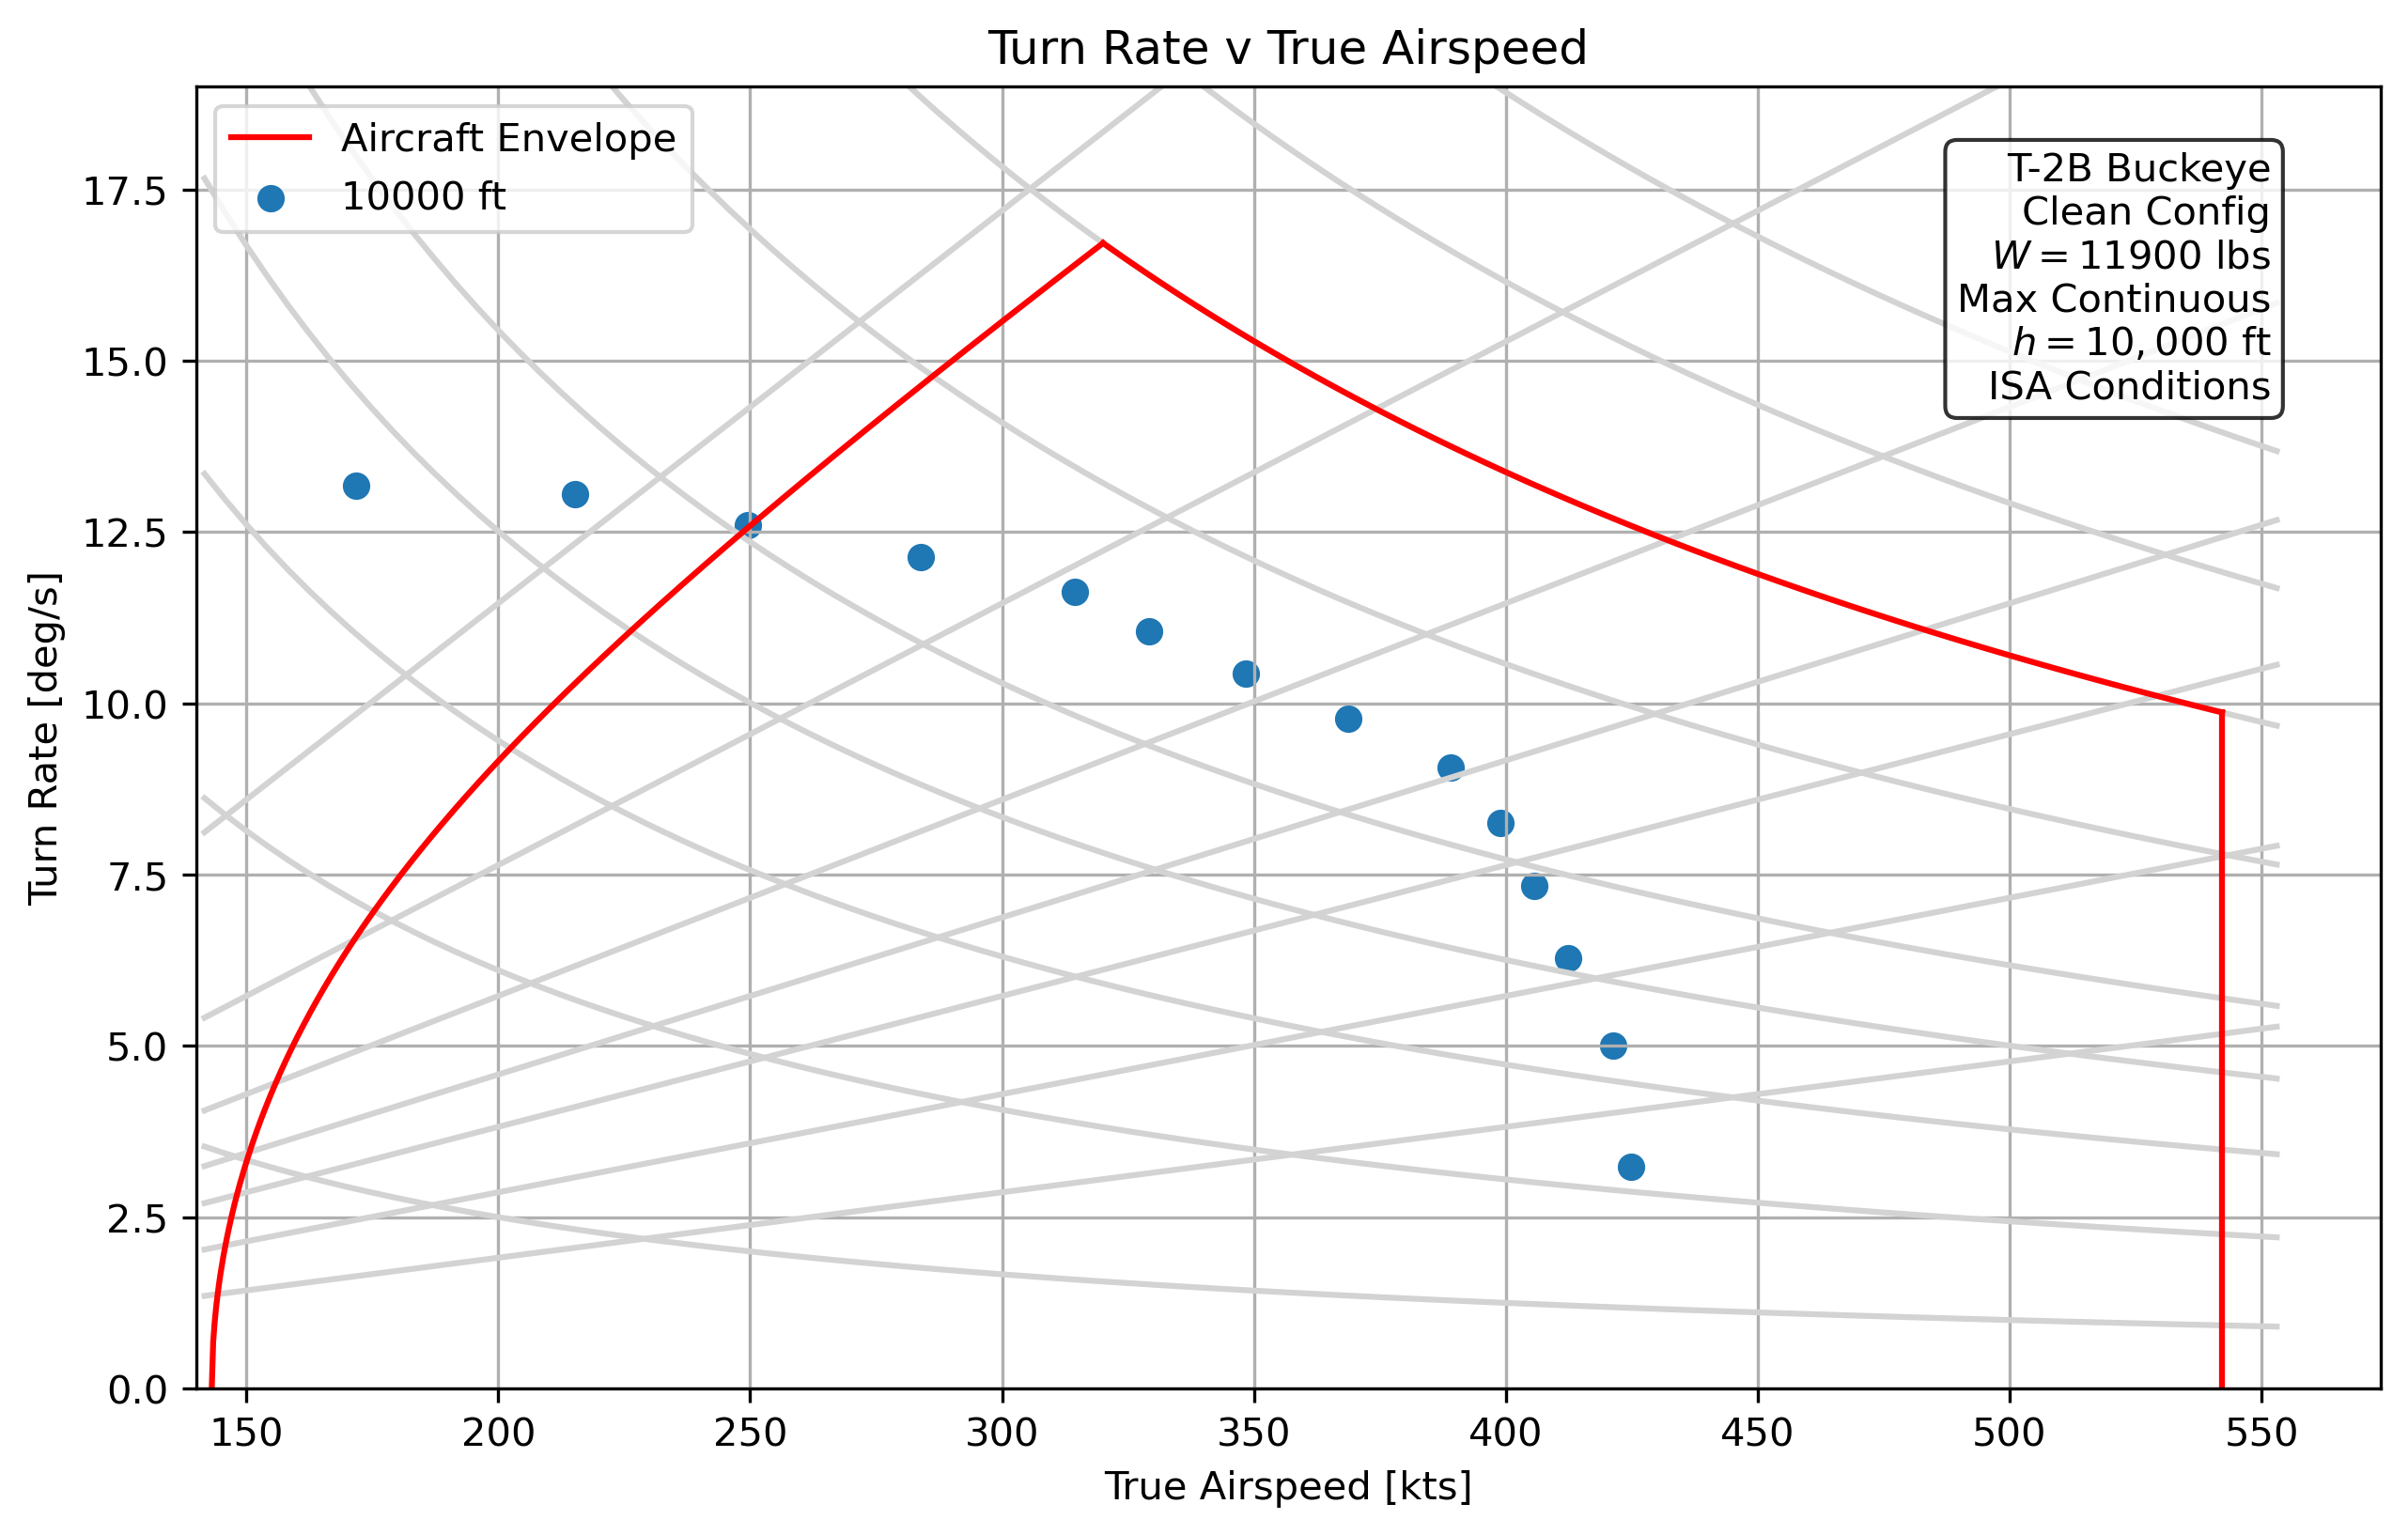

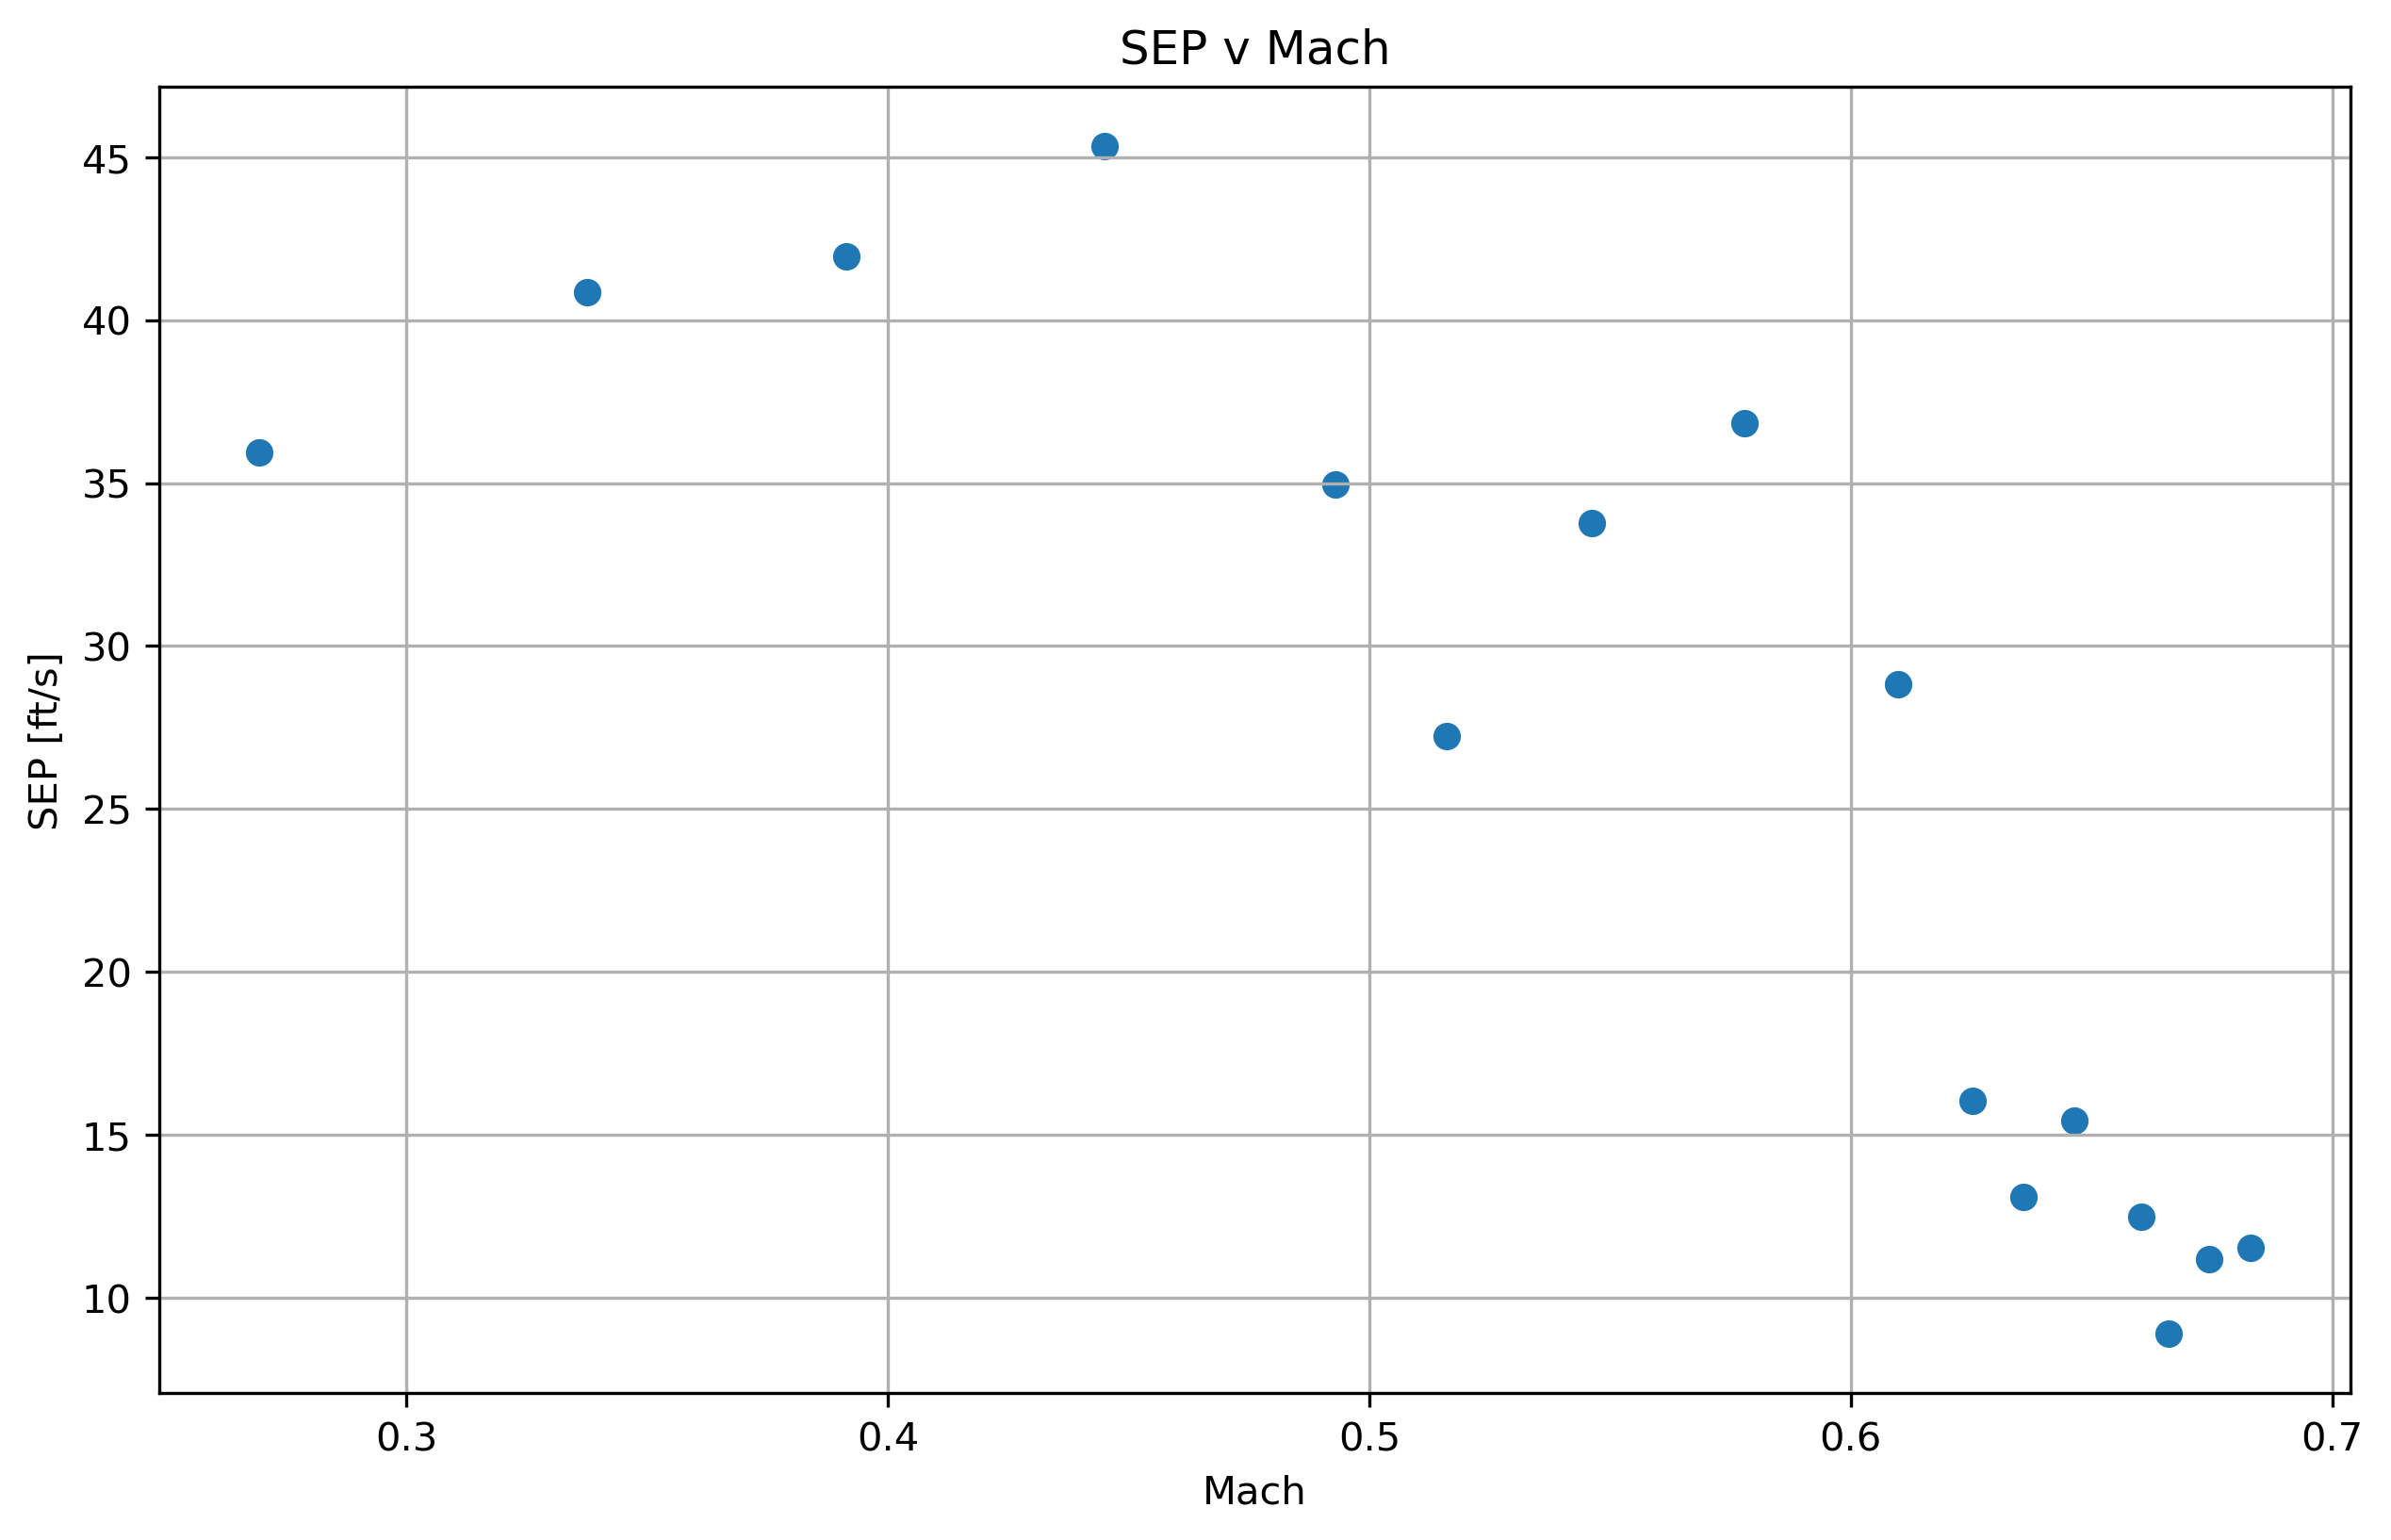

,Time [s],Vi [kts],Hi [ft],TT [℃],Wf [lbs],ZFW [lbs],ΔHic (AFM) [ft],ΔHpc (AFM) [ft],ΔVic (AFM) [kts],ΔVpc (AFM) [kts],...,dVt/dt [ft/s^2],dVt/dt [no fit],sep [ft/s],sep [no fit],ROC [ft/min],nz [g],Vts [fps],ωs [rad/s],ωs [deg/s],Rs [ft]
0,0,148,10010,-8,2800,8620,0,0,0,0,...,5.868849,7.348342,28.361957,35.943055,1701.717446,2.225193,278.106587,0.229943,13.174757,1209.459408
1,10,186,9940,-8,2800,8620,0,0,0,0,...,5.647452,6.571344,34.911183,40.845245,2094.671004,2.662934,348.596317,0.227761,13.049771,1530.532448
2,20,216,9930,-8,2800,8620,0,0,0,0,...,5.204657,5.791625,37.584971,41.956133,2255.098270,2.939810,404.179178,0.220036,12.607154,1836.874676
3,30,246,9950,-8,2800,8620,0,0,0,0,...,4.761862,5.474314,39.300773,45.335358,2358.046373,3.186947,459.709850,0.211756,12.132709,2170.944216
4,40,273,9930,-8,2800,8620,0,0,0,0,...,4.319066,3.825303,39.589989,34.957443,2375.399316,3.364498,509.205018,0.202953,11.628338,2508.982715
5,50,286,9940,-8,2800,8620,0,0,0,0,...,3.876271,2.864796,37.183651,27.248569,2231.019059,3.347532,533.099081,0.192784,11.045693,2765.270457
6,60,303,9940,-8,2800,8620,0,0,0,0,...,3.433476,3.328607,34.848792,33.758701,2090.927519,3.347294,564.166715,0.182153,10.436611,3097.209533
7,70,321,9940,-8,2800,8620,0,0,0,0,...,2.990681,3.422122,32.099227,36.844638,1925.953610,3.322350,596.959102,0.170738,9.782569,3496.345006
8,80,339,9960,-8,2800,8620,0,0,0,0,...,2.547886,2.548568,28.812639,28.820551,1728.758326,3.255529,629.820837,0.158247,9.066875,3979.990294
9,90,348,9930,-8,2800,8620,0,0,0,0,...,2.105091,1.410837,24.315520,16.053985,1458.931192,3.062060,645.853908,0.144159,8.259681,4480.161487


In [167]:
plt.figure(figsize=(10, 6), dpi=300)

for i in range(0, len(g_lines)):
    plt.plot(lines_speeds, g_lines_turn_rates[i], color="lightgray")

for i in range(0, len(radius_lines)):
    plt.plot(radius_lines_speeds, radius_lines_turn_rates[i], color="lightgray")

plt.plot(
    lift_boundary_speeds,
    lift_boundary_turn_rates,
    label="Aircraft Envelope",
    color="red",
)
plt.plot(nz_boundary_speeds, nz_boundary_turn_rates, color="red")
plt.plot(mmo_speeds, mmo_turn_rates, color="red")

plt.scatter(
    level_accel_data["Vt [kts]"], level_accel_data["ωs [deg/s]"], label=f"{altitude} ft"
)

textstr = "\n".join(
    (
        r"T-2B Buckeye",
        r"Clean Config",
        r"$W = 11900$ lbs",
        r"Max Continuous",
        r"$h = 10,000$ ft",
        r"ISA Conditions",
    )
)

# Add the textbox
props = dict(boxstyle="round", facecolor="white", alpha=0.8)
plt.gca().text(
    0.95,
    0.95,
    textstr,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=props,
)


plt.xlabel("True Airspeed [kts]")
plt.ylabel("Turn Rate [deg/s]")
plt.title("Turn Rate v True Airspeed")
plt.legend(loc='upper left')
plt.grid()
plt.xlim(140, None)
plt.ylim(0, 19)
plt.show()

plt.figure(figsize=(10, 6), dpi=300)
plt.scatter(level_accel_data["Mach"], level_accel_data["sep [no fit]"])
plt.xlabel("Mach")
plt.ylabel("SEP [ft/s]")
plt.title("SEP v Mach")
plt.grid()
plt.show()
level_accel_data